In [40]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
df_k5000 = pd.read_csv('../data/dataset/5.df_k5000_clustering.csv', index_col=0)
df_k5100 = pd.read_csv('../data/dataset/5.df_k5100_clustering.csv', index_col=0)
df_k5200 = pd.read_csv('../data/dataset/5.df_k5200_clustering.csv', index_col=0)
df_k5300 = pd.read_csv('../data/dataset/5.df_k5300_clustering.csv', index_col=0)
df_k5400 = pd.read_csv('../data/dataset/5.df_k5400_clustering.csv', index_col=0)
df_k5500 = pd.read_csv('../data/dataset/5.df_k5500_clustering.csv', index_col=0)
df_k5600 = pd.read_csv('../data/dataset/5.df_k5600_clustering.csv', index_col=0)
df_k5700 = pd.read_csv('../data/dataset/5.df_k5700_clustering.csv', index_col=0)
df_k5800 = pd.read_csv('../data/dataset/5.df_k5800_clustering.csv', index_col=0)
df_k5900 = pd.read_csv('../data/dataset/5.df_k5900_clustering.csv', index_col=0)

In [42]:
def concat_frames(frames):
  diff = 0
  for i in range(len(frames)):
    f = frames[i]
    f['cluster'] = f['cluster'].astype('int') + (5000*i)+diff 
    frames[i] = f
    diff = diff + 1 * 100
  result = pd.concat(frames, axis=0)
  return result

In [43]:
candidates_full_cols = concat_frames([df_k5000, df_k5100, df_k5200, df_k5300, df_k5400,
                                  df_k5500, df_k5600, df_k5700, df_k5800, df_k5900])

In [44]:
len(candidates_full_cols['cluster'].unique())

51700

In [45]:
candidates_full_cols

,cell_id,cluster,table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,87958702,3178,1,20220614,2,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
1,87958702,3178,1,20220629,3,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
2,87958702,3178,1,20220630,4,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
3,87958702,3178,1,20220616,4,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV Infra,5,3.829
4,87958702,3178,1,20220615,3,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457715,85510782,49086,2,20220621,2,4146,용인시,41461259,남사읍,127.130890,37.155083,MALE,10,EV라운지,1,14.280
457716,86103003,50148,2,20220625,6,4146,용인시,41463575,동백2동,127.151190,37.271423,FEMALE,11,하이차저,4,8.554
457717,87030893,47946,2,20220621,2,4146,용인시,41461520,역삼동,127.184000,37.248080,MALE,8,EV라운지,4,3.346
457718,84807207,47175,2,20220608,3,4146,용인시,41465550,죽전2동,127.105225,37.326714,FEMALE,10,EV라운지,4,4.055


### TODO
-  groupby, sum
- 데이터 형식 바꾸기. cluster: subset, cell_id: element, count_cust: cost

In [46]:
candidates = candidates_full_cols.copy().groupby(['cluster', 'cell_id']).sum().reset_index()

In [47]:
candidates = candidates.copy()[['cluster', 'cell_id', 'count_cust']]

In [48]:
from collections import defaultdict

universe = set([])
subsets = defaultdict(set)
demands = defaultdict(int)

for _, r in candidates.iterrows():
  cluster, cell_id, count_cust = r
  
  cell_id = str(int(cell_id))
  cluster = str(int(cluster))
  universe.add(cell_id)
  subsets[cluster].add(cell_id)
  demands[cell_id] = count_cust

In [49]:
print(len(subsets))
print(len(demands))

51700
18547


In [50]:
def greedy_set_cover(universe, subsets, costs):
    elements = set(e for s in subsets.keys() for e in subsets[s])
    # elements don't cover universe -> invalid input for set cover
    if elements != universe:
        return None

    # track elements of universe covered
    covered = set()
    cover_sets = []

    while covered != universe:
        min_cost_elem_ratio = float("inf")
        min_set = None
        # find set with minimum cost:elements_added ratio
        for s, elements in subsets.items():
            new_elements = len(elements - covered)
            # set may have same elements as already covered -> new_elements = 0
            # check to avoid division by 0 error
            if new_elements != 0:
                cost_elem_ratio = costs[s] / new_elements
                if cost_elem_ratio < min_cost_elem_ratio:
                    min_cost_elem_ratio = cost_elem_ratio
                    min_set = s
        cover_sets.append(min_set)
        # union
        covered |= subsets[min_set]
    return cover_sets

In [51]:
def calculate_subset_demand(subsets, demands):
      total_demands = {}
      for subset, elements in subsets.items():
        cost = 0
        for e in elements:
          cost += demands[str(e)]
        
        total_demands[subset] = cost
        
      total_demands_recip = {}
      
      for k, v in total_demands.items():
        total_demands_recip[k] = 1/v
        
      return [total_demands, total_demands_recip]

In [52]:
total_demands, total_demands_recip = calculate_subset_demand(subsets, demands)

In [53]:
# total_demands
print(len(total_demands_recip))

51700


In [54]:
cover = greedy_set_cover(universe, subsets, total_demands_recip)

In [56]:
cover_df = pd.DataFrame(cover)
cover_df.columns = ['cluster']
candidates_full_cols['cluster'] = candidates_full_cols['cluster'].astype('str')

In [57]:
candidates_full_cols

,cell_id,cluster,table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,87958702,3178,1,20220614,2,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
1,87958702,3178,1,20220629,3,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
2,87958702,3178,1,20220630,4,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
3,87958702,3178,1,20220616,4,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV Infra,5,3.829
4,87958702,3178,1,20220615,3,4146,용인시,41461256,이동읍,127.216920,37.188220,MALE,12,EV라운지,4,3.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457715,85510782,49086,2,20220621,2,4146,용인시,41461259,남사읍,127.130890,37.155083,MALE,10,EV라운지,1,14.280
457716,86103003,50148,2,20220625,6,4146,용인시,41463575,동백2동,127.151190,37.271423,FEMALE,11,하이차저,4,8.554
457717,87030893,47946,2,20220621,2,4146,용인시,41461520,역삼동,127.184000,37.248080,MALE,8,EV라운지,4,3.346
457718,84807207,47175,2,20220608,3,4146,용인시,41465550,죽전2동,127.105225,37.326714,FEMALE,10,EV라운지,4,4.055


In [58]:
cover_df.shape[0]

5233

In [59]:
clusters_df = pd.merge(cover_df, candidates_full_cols, how='left', on='cluster')
clusters_df

,cluster,cell_id,table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,7056,83943045,1,20220620,1,4146,용인시,41463550,서농동,127.075294,37.229260,MALE,6,EV라운지,6,7.439
1,7056,83943045,1,20220620,1,4146,용인시,41463550,서농동,127.075294,37.229260,MALE,7,하이차저,5,3.802
2,7056,83943045,1,20220613,1,4146,용인시,41463550,서농동,127.075294,37.229260,MALE,9,EV라운지,2,7.393
3,7056,83943045,1,20220607,2,4146,용인시,41463550,서농동,127.075294,37.229260,MALE,10,EV라운지,5,10.836
4,7056,83943045,1,20220625,6,4146,용인시,41463550,서농동,127.075294,37.229260,FEMALE,11,EV라운지,4,13.982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911258,2520,88902746,1,20220604,6,4146,용인시,41461540,동부동,127.250010,37.234720,MALE,9,EV라운지,4,3.076
911259,3174,85510926,2,20220604,6,4146,용인시,41463540,기흥동,127.130580,37.219982,FEMALE,7,EV라운지,4,3.076
911260,3540,90918630,1,20220622,3,4146,용인시,41461360,양지면,127.321020,37.239353,MALE,9,EV라운지,2,3.071
911261,3120,89974491,2,20220620,1,4146,용인시,41461340,원삼면,127.288010,37.150060,MALE,5,EV라운지,4,3.053


### Coverage

- 수요가 발생한 노드의 수: `len(df_k1000['cell_id'].unique())` = 18547
- 커버 가능한 노드의 수: `len(clusters_df['cell_id'].unique())` = 17976

커버리지 = 수요노드 / 커버노드 = 17976 / 18547 = 96.92%


In [60]:
demand_count = len(clusters_df['cell_id'].unique())
covered_count = len(df_k5000['cell_id'].unique())
print(demand_count) #수요가 발생한 노드의 수
print(covered_count) #커버 가능한 노드의 수

# print(demand_count / covered_count * 100)


18547
18547


## Cluster의 중심 좌표 구하기

In [61]:
# cluster로 그룹화 후 개별 데이터프레임으로 쪼개기

grouped_clusters_df = clusters_df.groupby('cluster')
groups = [grouped_clusters_df.get_group(g).reset_index() for g in grouped_clusters_df.groups]

In [62]:
groups[1].head()

,index,cluster,cell_id,table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,911139,1001,90198563,2,20220609,4,4146,용인시,41461340,원삼면,127.295784,37.18883,FEMALE,8,하이차저,3,5.25


In [63]:
xcrds = []
ycrds = []
cluster_list = []

for g in groups:
  min_x, max_x, min_y, max_y = g['cell_xcrd'][0], g['cell_xcrd'][0], g['cell_ycrd'][0], g['cell_ycrd'][0]
  cluster = g['cluster'][0]
  for i, r in g.iterrows():
    min_x = min(min_x, r['cell_xcrd'])
    max_x = max(max_x, r['cell_xcrd'])
    min_y = min(min_y, r['cell_ycrd'])
    max_y = max(max_y, r['cell_ycrd'])
  
  cluster_list.append(cluster)
  xcrds.append((min_x + max_x) / 2)
  ycrds.append((min_y + max_y) / 2)

In [64]:
len(xcrds)

5233

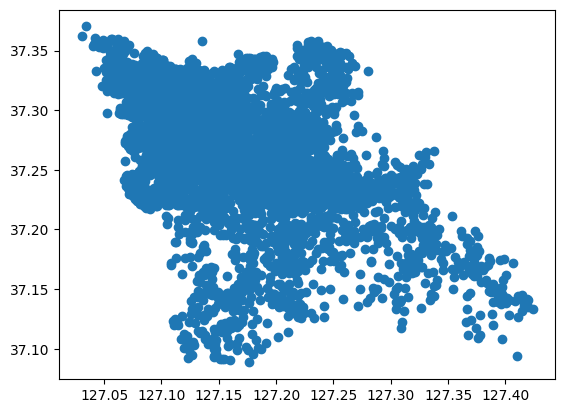

In [65]:
import matplotlib.pyplot as plt

plt.scatter(xcrds, ycrds)
plt.show()

In [66]:
len(xcrds)

5233

In [78]:
fin_df = pd.DataFrame(data=list(zip(cluster_list,xcrds,ycrds)), columns=["cluster", "xcrds", "ycrds"])

In [79]:
fin_df

,cluster,xcrds,ycrds
0,1000,127.191385,37.235027
1,1001,127.295784,37.188830
2,10039,127.110995,37.301495
3,10040,127.203855,37.144468
4,1005,127.258105,37.347407
...,...,...,...
5228,994,127.254190,37.248248
5229,995,127.204090,37.302216
5230,997,127.317470,37.192700
5231,9986,127.086575,37.330033


In [80]:
fin_df.to_csv('../data/dataset/6.Candidate groups.csv')